### Dane treningowe

Ponieważ będziemy potrzebowali na czymś wytrenować naszą sieć neuronową skorzystamy z popularnego zbioru w Machine Learningu czyli MNIST. Zbiór ten zawiera ręcznie pisane cyfry od 0 do 9. Są to niewielkie obrazki o wielkości 28x28 pixeli.

Pobierzmy i załadujmy zbiór.

In [1]:
# skorzystamy z gotowej funkcji do pobrania tego zbioru
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

Zaimportujmy dodatkowe biblioteki do wyświetlania wykresów/obrazów oraz `numpy` który jest paczką do obliczeń na macierzach

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns  # można osobno doinstalować tą paczke (rysuje ładniejsze wykresy)

import numpy as np

# pozwala na rysowanie w notebooku (nie otwiera osobnego okna)
%matplotlib inline

Sprawdźmy ile jest przykładów w zbiorze

In [3]:
print(mnist.data.shape)  # 28x28
print(mnist.target.shape)

(70000, 784)
(70000,)


Teraz wyświetlmy pare przykładowych obrazków ze zbioru

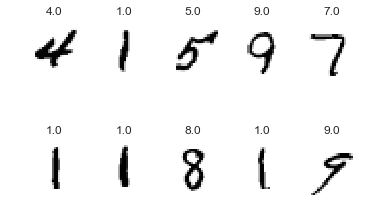

In [4]:
for i in range(10):
    r = np.random.randint(0, len(mnist.data))
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(mnist.target[r])
    plt.imshow(mnist.data[r].reshape((28, 28)))
plt.show()

## Tworzenie sieci neuronowej

Żeby za bardzo nie komplikować sprawy stworzymy sieć o trzech warstwach. Na początku ustalmy ilość neuronów w każdej z warstw. Ponieważ wielkość obrazka to 28x28 pixeli potrzebujemy więc 784 neuronów wejściowych. W warstwie ukrytej możemy ustawić ilość na dowolną. Ponieważ mamy do wyboru 10 różnych cyfr tyle samo neuronów damy w warstwie wyjściowej.

In [5]:
input_layer = 784
hidden_layer = 128
output_layer = 10

Kluczowym elementem sieci neuronowych są ich wagi na połączeniach między neuronami. Aktualnie po prostu wczytamy już wytrenowane wagi dla sieci.

In [6]:
# wcztanie już wytrenowanych wag (parametrów)
import h5py
with h5py.File('weights.h5', 'r') as file:
    W1 = file['W1'][:]
    W2 = file['W2'][:]

In [7]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

Obliczenia wykonywane przez sieć neuronową można rozrysować w postaci grafu obliczeniowego, gdzie każdy z wierzchołków reprezentuje jakąś operację na wejściach. Wykorzystywana przez nas sieć przedstawiona jest na grafie poniżej (`@` to mnożenie macierzy):

![](img/nn-forward-graph.png "")

In [8]:
def forward_pass(x, w1, w2):
    # x - wejście sieci
    # w1 - parametry warstwy ukrytej
    # w2 - parametry warstwy wyjściowej
    
    z1 = x @ w1
    h1 = sigmoid(z1)
    
    z2 = h1 @ w2
    h2 = sigmoid(z2)
    
    return h2

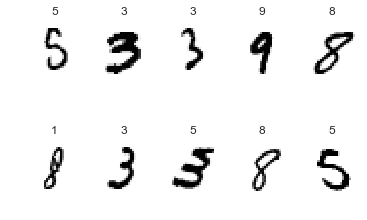

In [9]:
# uruchomienie sieci i sprawdzenie jej działania
# użyj funkcji forward_pass dla kilku przykładów i zobacz czy sieć odpowiada poprawnie
sample = np.random.choice(len(mnist.data), size=(10,), replace=False)
x_ex = mnist.data[sample]
y_ex = mnist.target[sample]

nn_ans = forward_pass(x_ex, W1, W2)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(np.argmax(nn_ans[i]))
    plt.imshow(x_ex[i].reshape((28, 28)))
plt.show()

## Trenowanie sieci (Back-propagation)

Należy przygotować dane pod trenowanie sieci. Chodzi tu głównie o zakodowanie `mnist.target` w sposób 'one-hot encoding'. Czyli: $$y = \left[ \begin{matrix} 0 \\ 1 \\ 2 \\ \vdots \\ 8 \\ 9 \end{matrix} \right] \Longrightarrow \left[ \begin{matrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{matrix} \right]$$

**Uwaga:** aktualnie wszystkie dane są posortowane względem odpowiedzi. Czyli wszystkie zera są na początku póżniej są jednyki, itd. Takie ustawienie może w znaczący sposób utrudnić trenowanie sieci. Dlatego należy dane na starcie "przetasować". Trzeba przy tym pamiętać, żeby wejścia dalej odpowiadały tym samym wyjściom.

In [10]:
x_train = mnist.data
y_train = np.eye(10)[mnist.target.astype(np.int32)]

shuffle = np.random.permutation(len(x_train))
x_train = x_train[shuffle]
y_train = y_train[shuffle]

Na starcie parametry są zwyczajnie losowane. Wykorzystamy do tego funkcje `np.random.rand(dim_1, dim_2, ..., dim_n)` losuje ona liczby z przedziału $[0, 1)$ i zwraca tensor o podanych przez nas wymiarach.

**Uwaga:** Mimo, że funkcja zwraca liczby z przedziału $[0, 1)$ nasze startowe parametry powinny być z przedziału $(-0.01, 0.01)$

In [11]:
W1 = 0.01 * (2. * np.random.rand(input_layer, hidden_layer) - 1.)
W2 = 0.01 * (2. * np.random.rand(hidden_layer, output_layer) - 1.)

## Implementacja propagacji wstecznej

Podobnie jak przy optymalizowaniu funkcji, do wyliczenia gradientów wykorzystamy _backprop_. Graf obliczeniowy jest trochę bardziej skomplikowany. (`@` oznacza mnożenie macierzy)

![Backward graph](img/nn-backward-graph.png "Graph")

Do zaimplementowania funkcji `back_prop(...)` będziemy jeszcze potrzebować pochodnych dla naszych funkcji oraz funkcje straty.

In [12]:
def loss_func(y_true, y_pred):
    # y_true - poprawna odpowiedź
    # y_pred - odpowiedź wyliczona przez sieć neuronową
    
    return np.mean(np.square(y_true - y_pred))

In [13]:
def sigmoid_derivative(x):
    # implementacja
    return x * (1. - x)

In [14]:
def loss_derivative(y_true, y_pred):
    # y_true - poprawna odpowiedź
    # y_pred - odpowiedź wyliczona przez sieć neuronową
    
    return -2. * (y_true - y_pred) / len(y_pred)

In [15]:
def back_prop(x, y, w1, w2):
    # x - wejście sieci
    # y - poprawne odpowiedzi
    # w1 - parametry warstwy ukrytej
    # w2 - parametry warstwy wyjściowej
    
    # zastąp linie pod spodem kodem z funkcji forward_pass
    # >>>
    z1 = x @ w1
    h1 = sigmoid(z1)
    
    z2 = h1 @ w2
    h2 = sigmoid(z2)
    # <<<
    
    loss = loss_func(y, h2)
    
    # backprop: loss = loss_func(y, h2)
    dh2 = loss_derivative(y, h2)
    
    # backprop: h2 = sigmoid(z2)
    dz2 = sigmoid_derivative(h2) * dh2
    
    # backprop: z2 = h1 @ w2
    dh1 = dz2 @ w2.T
    dw2 = h1.T @ dz2
    
    # backprop: h1 = sigmoid(z1)
    dz1 = sigmoid_derivative(h1) * dh1
    
    # backprop: z1 = x @ w1
    dx = dz1 @ w1.T
    dw1 = x.T @ dz1
    
    return loss, dw1, dw2

Napiszemy jeszcze funkcje, która będzie wykonywała jeden krok optymalizacji dla podanych parametrów i ich gradientów o podanym kroku.

In [16]:
def apply_gradients(w1, w2, dw1, dw2, learning_rate):
    # w1 - parametry warstwy ukrytej
    # w2 - parametry warstwy wyjściowej
    # dw1 - gradienty dla parametrów warstwy ukrytej
    # dw2 - gradienty dla parametrów warstwy wyjściowej
    # learning_rate - krok optymalizacji
    
    w1 -= learning_rate * dw1
    w2 -= learning_rate * dw2
    
    return w1, w2

Żeby móc lepiej ocenić postęp uczenia się sieci napiszemy funkcje, która będzie wyliczać jaki procent odpowiedzi udzielanych przez sieć neuronową jest poprawny.

In [17]:
def accuracy(x, y, w1, w2):
    # x - wejście sieci
    # y - poprawne odpowiedzi
    # w1 - parametry warstwy ukrytej
    # w2 - parametry warstwy wyjściowej
    
    # hint: użyj funkcji forward_pass i np.argmax
    pred = forward_pass(x, w1, w2)
    return np.sum(np.isclose(np.argmax(pred, axis=1), np.argmax(y, axis=1))) / len(x)

W końcu możemy przejść do napisania głównej pętli uczącej.

In [18]:
nb_epoch = 5  # ile razy będziemy iterować po danych treningowych
learning_rate = 0.001
batch_size = 16  # na jak wielu przykładach na raz będziemy trenować sieć


Epoch 0
[69985/70000] loss: 0.085540 - accuracy:   0.437500
Epoch 1
[69985/70000] loss: 0.057606 - accuracy:   0.750000
Epoch 2
[69985/70000] loss: 0.038187 - accuracy:   0.875000
Epoch 3
[69985/70000] loss: 0.028400 - accuracy:   0.937500
Epoch 4
[69985/70000] loss: 0.021775 - accuracy:   1.000000

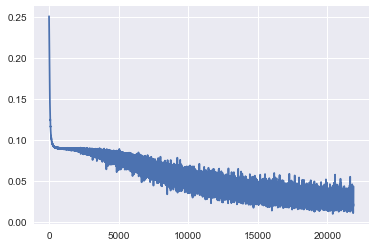

In [19]:
losses = []
for epoch in range(nb_epoch):
    print('\nEpoch %d' % (epoch,))
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # wykonaj back_prop dla pojedynczego batch'a
        loss, dw1, dw2 = back_prop(x_batch, y_batch, W1, W2)
        
        # zaktualizuj parametry
        W1, W2 = apply_gradients(W1, W2, dw1, dw2, learning_rate)
        
        losses.append(loss)
        print('\r[%5d/%5d] loss: %8.6f - accuracy: %10.6f' % (i + 1, len(x_train),
                  loss, accuracy(x_batch, y_batch, W1, W2)), end='')
        
plt.plot(losses)
plt.show()

In [20]:
print('Dokładność dla całego zbioru:', accuracy(x_train, y_train, W1, W2))

Dokładność dla całego zbioru: 0.916757142857
